In [1]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2

In [2]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)

In [3]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
# Path and save to excel
#BasicPath=os.getcwd() # for HPC
BasicPath = "D:/OneDrive - Imperial College London/SimDataSave/P3R13/Paper/"  #'D:/OneDrive - Imperial College London/SimDataSave/P3R13/'; 
Target  = 'ManyCycAge_1C/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [4]:
# define parameter of double and single 
Para_dict_Same = {
   ################################# Same for single and double:
   "Total ageing cycles":[2000,],
   "SaveAsList":[  [100,20,1,1,1,1],  ],
   "Ageing temperature":[25,],
   "Mesh list":[ [5,5,5,60,30], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   # solvent diffusion parameters:
   "EC initial concentration in electrolyte [mol.m-3]":[3500],
   "Typical EC concentration [mol.m-3]":[3500,],

   "Negative electrode porosity":[0.25],
   "SEI resistivity [Ohm.m]":[2e5,],
   "Initial inner SEI thickness [m]":[1.2362e-08,],
   "Initial outer SEI thickness [m]":[1.2362e-08,],
   "Contact resistance [Ohm]":[6e-3],
   "Cation transference number":[
    "electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Con"],
   "Electrolyte conductivity [S.m-1]":[
    "electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Con"],
   "Electrolyte diffusivity [m2.s-1]":[
    "electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Con"],
   # SEI
   "Inner SEI lithium interstitial diffusivity [m2.s-1]":[5e-19,], 
   # 6e-18: j_SEI=6mA/m2;   3e-17, j=20mA/m2
}

Para_dict_DD_ONLY = {
    "Model option":[{
        "calculate discharge energy":"true",
        "SEI":"interstitial-diffusion limited",            
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",   
        "solvent diffusion": "double spatial consume w refill",
        "electrolyte conductivity": "sol full"  ,
        "contact resistance":"true",  
        },],
    ################################# Need to be different between single and double:
    "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10","Cross_diffusivity_1p5E_12",], # 
    "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
    "EC transference number":["EC_transference_number",],
    "Measured dLJP_dcEC": ["dLJP_Two_Species_dco_Jung2023",],
    "Measured dLJP_dce": ["dLJP_Two_Species_dce_Jung2023",],
}
Para_dict_SD_ONLY = {
    "Model option":[{
        "calculate discharge energy":"true",
        "SEI":"interstitial-diffusion limited",            
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",   
        "solvent diffusion": "single no consume wo refill",
        "electrolyte conductivity": "full"  ,
        "contact resistance":"true",
        },],
    ################################# fake, must have only one option
    "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10"],
    "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
    "EC transference number":["EC_transference_number",],
    "Measured dLJP_dce":["dLJP_One_Specie_dce_Jung2023",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))
Para_dict_list = [ Para_SD[0],Para_DD[0],Para_DD[1],  ]
print(f"Total scan case is {len(Para_dict_list)}")


2 1
Total scan case is 3


In [5]:
keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Negative electrode porosity",
    "CCend Positive electrode potential [V]",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend EC concentration [mol.m-3]",
    "CCend EC transference number",
    "CCend c(EC) over c(Li+)",
    "CCend Electrolyte current density [A.m-2]",
    "CCend Electrolyte diffusivity [m2.s-1]",
    "CCend Electrolyte conductivity [S.m-1]",
    "CCend Negative electrode SEI interfacial current density [A.m-2]",

    "CDend Negative electrode porosity",
    "CDend Positive electrode potential [V]",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend EC concentration [mol.m-3]",
    "CDend EC transference number",
    "CDend c(EC) over c(Li+)",
    "CDend Electrolyte current density [A.m-2]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
    "CDend Negative electrode SEI interfacial current density [A.m-2]",
]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CC Time [h]",
    "CV Time [h]",
    "CD Terminal voltage [V]",
    "CC Terminal voltage [V]",
    "CV Terminal voltage [V]",
    "CD X-averaged battery reaction overpotential [V]",
    "CD X-averaged battery concentration overpotential [V]",
    "CD X-averaged EC concentration overpotential [V]", 
    "CD X-averaged battery electrolyte ohmic losses [V]",
    "CD X-averaged battery solid phase ohmic losses [V]",
    "CD X-averaged SEI interfacial current density [A.m-2]",
    "CC X-averaged battery reaction overpotential [V]",
    "CC X-averaged battery concentration overpotential [V]",
    "CC X-averaged EC concentration overpotential [V]", 
    "CC X-averaged battery electrolyte ohmic losses [V]",
    "CC X-averaged battery solid phase ohmic losses [V]",
    "CC X-averaged SEI interfacial current density [A.m-2]",
]
keys_cyc_AGE = [   # default: CDend
    "Discharge capacity [A.h]",
    "CCsta Discharge capacity [A.h]",
    "CCend Discharge capacity [A.h]",
    "CVsta Discharge capacity [A.h]",
    "CVend Discharge capacity [A.h]",
    "CDsta Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CCsta Loss of capacity to SEI [A.h]",
    "CCend Loss of capacity to SEI [A.h]",
    "CVsta Loss of capacity to SEI [A.h]",
    "CVend Loss of capacity to SEI [A.h]",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    "CDend Loss of active material in positive electrode [%]",
    "CDend Loss of active material in negative electrode [%]",
    "CDend Total EC in electrolyte [mol]",
    "CDend Total EC in electrolyte and SEI [mol]",
    "CDend Total lithium in electrolyte [mol]",
    "CDend Total lithium in particles [mol]",
]
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];


In [6]:
# define experiments and scan!
V_max = 4.2;        V_min = 2.5; 
exp_AGE = [
   (f"Discharge at 1 C until {V_min} V", 
   f"Charge at 1 C until {V_max} V",  # (5 minute period)
   f"Hold at {V_max} V until C/20"),  ]# (5 minute period)
exp_AGE_2 = [
   (f"Discharge at 1 C until {V_min} V (5 seconds period)", 
   f"Charge at 1 C until {V_max} V (5 seconds period)", 
   f"Hold at {V_max} V until C/20 (5 seconds period)"),]
# step index for ageing
exp_AGE_CD = [ (
   f"Discharge at 1 C until {V_min} V (1 seconds period)",   ) ]
exp_AGE_CC = [ (
   f"Charge at 1 C until {V_max} V (1 seconds period)" ) ]
exp_AGE_CV = [ (
   f"Hold at {V_max} V until C/20 (1 seconds period)" ) ]
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

Exp_AGE_List     = [
    exp_AGE,exp_AGE,exp_AGE_2,
    exp_AGE_CD,exp_AGE_CC,exp_AGE_CV];
cycle_no = -1; 
exp_index_pack = [
   cycle_no,step_AGE_CD,
   step_AGE_CC,step_AGE_CV,];

book_name_xlsx = 'Landes_int.xlsx';sheet_name_xlsx = 'Results';
Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];
# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.extend([ "exp_AGE_text", 
   "Cap Loss","LLI to SEI",
   "LAM to Neg","LAM to Pos",
   "Error"])
Values_1 = [head_list,];
index_list = np.arange(1,len(Para_dict_list)+1,1)
for Scan_i,Para_dict_i in zip(index_list,Para_dict_list):
    value_list_temp = list(Para_dict_i.values())
    values = []
    for value_list_temp_i in value_list_temp:
        values.append(str(value_list_temp_i))
    values.insert(0,str(Scan_i))
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, Values_1)   

Successfully create a excel file


Start Now! Scan 1.
Confirm: using interstitial-diffusion limited
try to run 100 cycles


At t = 0.00537573, , mxstep steps taken before reaching tout.
At t = 0.00535367, , mxstep steps taken before reaching tout.
At t = 0.00533168, , mxstep steps taken before reaching tout.
At t = 0.00530974, , mxstep steps taken before reaching tout.
At t = 0.00528789 and h = 4.58471e-019, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00526609, , mxstep steps taken before reaching tout.
At t = 0.00524438, , mxstep steps taken before reaching tout.
At t = 0.00522273 and h = 2.32516e-019, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00520114, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0.00517962 and h = 6.22165e-022, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00515816 and h = 1.21969e-019, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface

Succeed! Now it is the 100th cycles
try to run 100 cycles
Succeed! Now it is the 200th cycles
try to run 100 cycles
Succeed! Now it is the 300th cycles
try to run 100 cycles


At t = 0.00538286, , mxstep steps taken before reaching tout.
At t = 0.00536775, , mxstep steps taken before reaching tout.
At t = 0.00535262, , mxstep steps taken before reaching tout.


Succeed! Now it is the 400th cycles
try to run 100 cycles


At t = 0.0053375, , mxstep steps taken before reaching tout.
At t = 0.00532238, , mxstep steps taken before reaching tout.
At t = 0.00530726, , mxstep steps taken before reaching tout.
At t = 0.00529214, , mxstep steps taken before reaching tout.


Succeed! Now it is the 500th cycles
try to run 100 cycles
Succeed! Now it is the 600th cycles
try to run 100 cycles
Succeed! Now it is the 700th cycles
try to run 100 cycles
Succeed! Now it is the 800th cycles
try to run 100 cycles
Succeed! Now it is the 900th cycles
try to run 100 cycles
Succeed! Now it is the 1000th cycles
try to run 100 cycles
Succeed! Now it is the 1100th cycles
try to run 100 cycles
Succeed! Now it is the 1200th cycles
try to run 100 cycles
Succeed! Now it is the 1300th cycles
try to run 100 cycles
Succeed! Now it is the 1400th cycles
try to run 100 cycles
Succeed! Now it is the 1500th cycles
try to run 100 cycles
Succeed! Now it is the 1600th cycles
try to run 100 cycles


At t = 0.000920398 and h = 2.50739e-046, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000836989, , mxstep steps taken before reaching tout.
At t = 0.000836991 and h = 5.59427e-042, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000627625, , mxstep steps taken before reaching tout.
At t = 0.000295288 and h = 5.98465e-048, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000211998 and h = 1.14084e-032, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 5.57331e-005, , mxstep steps taken before reaching tout.
At t = 5.57479e-005, , mxstep steps taken before reaching tout.
At t = 2.1933e-005 and h = 6.00068e-045, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.40149e-006, , mxstep steps taken before reaching tout.
At t = 2.40155e-006 and h = 2.9412e-047, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.40149e-006 and h = 2.56064e-044, the correc

Failed or took too long, shorten cycles
division by zero
try to run 20 cycles


At t = 0.000837082, , mxstep steps taken before reaching tout.
At t = 0.000920461 and h = 2.01575e-048, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000920412 and h = 7.69572e-042, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000837067 and h = 2.13347e-034, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000295427, , mxstep steps taken before reaching tout.
At t = 0.000212066, , mxstep steps taken before reaching tout.
At t = 5.58012e-005, , mxstep steps taken before reaching tout.
At t = 6.10748e-005 and h = 1.87478e-047, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.20088e-005 and h = 3.99087e-045, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.4773e-006 and h = 1.11825e-046, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.47725e-006 and h = 2.80751e-045, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.

Failed or took too long, shorten cycles
division by zero
try to run 1 cycles
Succeed! Now it is the 1601th cycles
try to run 1 cycles
Succeed! Now it is the 1602th cycles
try to run 1 cycles
Succeed! Now it is the 1603th cycles
try to run 1 cycles
Succeed! Now it is the 1604th cycles
try to run 1 cycles
Succeed! Now it is the 1605th cycles
try to run 1 cycles
Succeed! Now it is the 1606th cycles
try to run 1 cycles
Succeed! Now it is the 1607th cycles
try to run 1 cycles
Succeed! Now it is the 1608th cycles
try to run 1 cycles
Succeed! Now it is the 1609th cycles
try to run 1 cycles
Succeed! Now it is the 1610th cycles
try to run 1 cycles


At t = 0.00809894 and h = 3.57051e-042, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00308063, , mxstep steps taken before reaching tout.
At t = 0.000837455, , mxstep steps taken before reaching tout.
At t = 2.35605e-005, , mxstep steps taken before reaching tout.
At t = 2.35605e-005, , mxstep steps taken before reaching tout.
At t = 2.35605e-005 and h = 6.39968e-054, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.35589e-005 and h = 2.40975e-043, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.35616e-005 and h = 1.43385e-046, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.35609e-005 and h = 4.35288e-046, the corrector convergence failed repeatedly or with |h| = hmin.
2023-04-11 17:19:43.150 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Maximum number of decreased steps occurred at t=310.00000000000006 (final SolverError: '.../casadi/interfaces/sundials/idas_interfa

Failed or took too long, shorten cycles
Maximum number of decreased steps occurred at t=310.00000000000006 (final SolverError: '.../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=0.21767394276156193) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_failed_early=True` to return the solution object up to the point where failure occured.
try to run 1 cycles


At t = 0.00783603, , mxstep steps taken before reaching tout.
At t = 0.00290101 and h = 1.2898e-033, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000561708, , mxstep steps taken before reaching tout.
At t = 0.000561748 and h = 8.12399e-048, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.3646e-005 and h = 3.9983e-046, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.3646e-005, , mxstep steps taken before reaching tout.
At t = 2.3646e-005 and h = 2.54795e-047, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.36435e-005 and h = 3.73132e-046, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.36459e-005 and h = 7.83094e-051, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4.11399e-006 and h = 6.15343e-043, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4.11388e-006 and h = 1.83805e-046, the corrector convergence failed re

Succeed! Now it is the 1611th cycles
Succeed a single step and switch to next step normally
try to run 1 cycles
Failed or took too long, shorten cycles
initial condition is outside of variable bounds (0, inf) for variable 'Porosity times concentration(Negative electrode porosity times concentration, Separator porosity times concentration, Positive electrode porosity times concentration)'.
try to run 1 cycles
Failed or took too long, shorten cycles
initial condition is outside of variable bounds (0, inf) for variable 'Porosity times concentration(Negative electrode porosity times concentration, Separator porosity times concentration, Positive electrode porosity times concentration)'.
Exit as no options left
Finally finish 1611 cycles
Single step starts from 26
Not all solution has full cycles
Total line number is: 319
Total line number is: 319
Total line number is: 319
Total line number is: 319
Total line number is: 319
Total line number is: 319
Total line number is: 319
Total line numb

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Seems no empty solution
Successfully create a excel file
Scan No. 1 succeed! Saving succeed as well!
Start Now! Scan 2.
Confirm: using interstitial-diffusion limited
try to run 100 cycles


At t = 0.00536493, , mxstep steps taken before reaching tout.
At t = 0.00534201, , mxstep steps taken before reaching tout.
At t = 0.00531916, , mxstep steps taken before reaching tout.
At t = 0.00529641, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0.00527375, , mxstep steps taken before reaching tout.
At t = 0.00525116, , mxstep steps taken before reaching tout.
At t = 0.00522865, , mxstep steps taken before reaching tout.
At t = 0.00520624, , mxstep steps taken before reaching tout.
At t = 0.00518388, , mxstep steps taken before reaching tout.
At t = 0.00516163, , mxstep steps taken before reaching tout.
At t = 0.00513944, , mxstep steps taken before reaching tout.


Succeed! Now it is the 100th cycles
try to run 100 cycles
Succeed! Now it is the 200th cycles
try to run 100 cycles
Succeed! Now it is the 300th cycles
try to run 100 cycles
Succeed! Now it is the 400th cycles
try to run 100 cycles


At t = 0.00537219, , mxstep steps taken before reaching tout.
At t = 0.0053587, , mxstep steps taken before reaching tout.
At t = 0.00534522, , mxstep steps taken before reaching tout.
At t = 0.00533173, , mxstep steps taken before reaching tout.
At t = 0.00531826 and h = 1.37411e-018, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00530479, , mxstep steps taken before reaching tout.
At t = 0.00529132, , mxstep steps taken before reaching tout.
At t = 0.00527785, , mxstep steps taken before reaching tout.
At t = 0.00526439, , mxstep steps taken before reaching tout.


Succeed! Now it is the 500th cycles
try to run 100 cycles
Succeed! Now it is the 600th cycles
try to run 100 cycles
Succeed! Now it is the 700th cycles
try to run 100 cycles
Succeed! Now it is the 800th cycles
try to run 100 cycles
Succeed! Now it is the 900th cycles
try to run 100 cycles
Succeed! Now it is the 1000th cycles
try to run 100 cycles
Succeed! Now it is the 1100th cycles
try to run 100 cycles
Succeed! Now it is the 1200th cycles
try to run 100 cycles
Succeed! Now it is the 1300th cycles
try to run 100 cycles
Succeed! Now it is the 1400th cycles
try to run 100 cycles
Succeed! Now it is the 1500th cycles
try to run 100 cycles
Succeed! Now it is the 1600th cycles
try to run 100 cycles
Succeed! Now it is the 1700th cycles
try to run 100 cycles
Succeed! Now it is the 1800th cycles
try to run 100 cycles
Succeed! Now it is the 1900th cycles
try to run 100 cycles
Succeed! Now it is the 2000th cycles
No single step
Seems no empty solution
Seems no empty solution
Seems no empty solut

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Seems no empty solution
Successfully create a excel file
Scan No. 2 succeed! Saving succeed as well!
Start Now! Scan 3.
Confirm: using interstitial-diffusion limited
try to run 100 cycles


At t = 0.00537239 and h = 5.73661e-019, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00534988, , mxstep steps taken before reaching tout.
At t = 0.00532744, , mxstep steps taken before reaching tout.
At t = 0.00530509, , mxstep steps taken before reaching tout.
At t = 0.00528281, , mxstep steps taken before reaching tout.
At t = 0.00526062, , mxstep steps taken before reaching tout.
At t = 0.0052385, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0.00521647 and h = 3.27431e-022, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00519452, , mxstep steps taken before reaching tout.
At t = 0.00517264, , mxstep steps taken before reaching tout.
At t = 0.00515084, , mxstep steps taken before reaching tout.
At t = 0.00512911 and h = 2.00224e-019, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00510745, , mxstep steps taken b

Succeed! Now it is the 100th cycles
try to run 100 cycles
Succeed! Now it is the 200th cycles
try to run 100 cycles
Succeed! Now it is the 300th cycles
try to run 100 cycles
Succeed! Now it is the 400th cycles
try to run 100 cycles


At t = 0.00537375, , mxstep steps taken before reaching tout.
At t = 0.0053603 and h = 5.31206e-019, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00534686, , mxstep steps taken before reaching tout.
At t = 0.00533343, , mxstep steps taken before reaching tout.
At t = 0.00532, , mxstep steps taken before reaching tout.
At t = 0.00530658 and h = 7.51489e-019, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
At t = 0.00529317, , mxstep steps taken before reaching tout.
At t = 0.00527977, , mxstep steps taken before reaching tout.
At t = 0.00526636 and h = 1.13679e-018, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:852: Linear solve failed
psetup failed: .../casadi/interfaces/sundials/idas

Succeed! Now it is the 500th cycles
try to run 100 cycles
Succeed! Now it is the 600th cycles
try to run 100 cycles
Succeed! Now it is the 700th cycles
try to run 100 cycles
Succeed! Now it is the 800th cycles
try to run 100 cycles
Succeed! Now it is the 900th cycles
try to run 100 cycles
Succeed! Now it is the 1000th cycles
try to run 100 cycles
Succeed! Now it is the 1100th cycles
try to run 100 cycles
Succeed! Now it is the 1200th cycles
try to run 100 cycles
Succeed! Now it is the 1300th cycles
try to run 100 cycles
Succeed! Now it is the 1400th cycles
try to run 100 cycles
Succeed! Now it is the 1500th cycles
try to run 100 cycles
Succeed! Now it is the 1600th cycles
try to run 100 cycles
Succeed! Now it is the 1700th cycles
try to run 100 cycles
Succeed! Now it is the 1800th cycles
try to run 100 cycles
Succeed! Now it is the 1900th cycles
try to run 100 cycles
Succeed! Now it is the 2000th cycles
No single step
Seems no empty solution
Seems no empty solution
Seems no empty solut

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Seems no empty solution
Successfully create a excel file
Scan No. 3 succeed! Saving succeed as well!


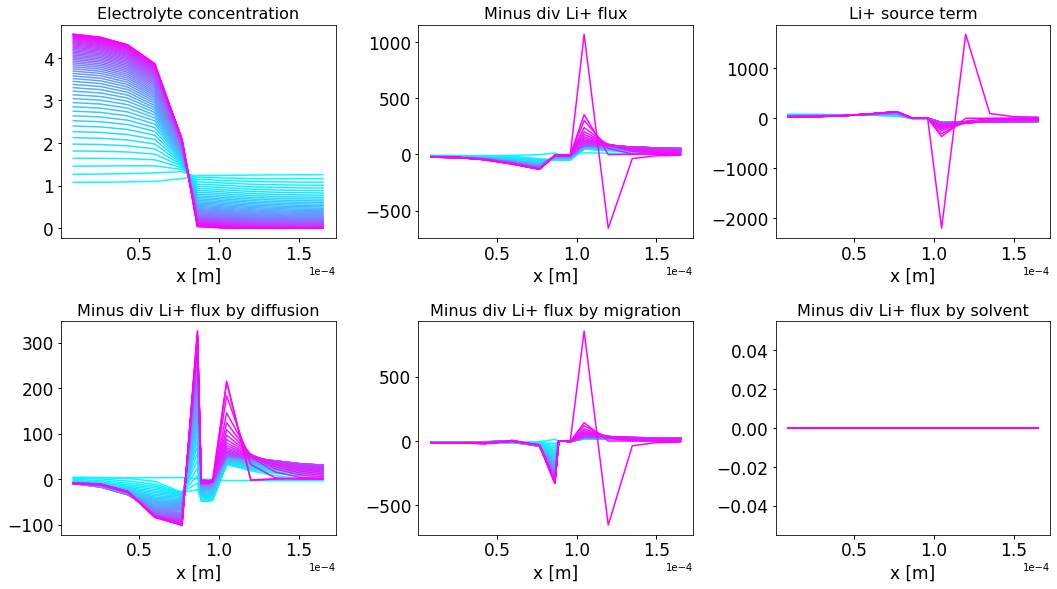

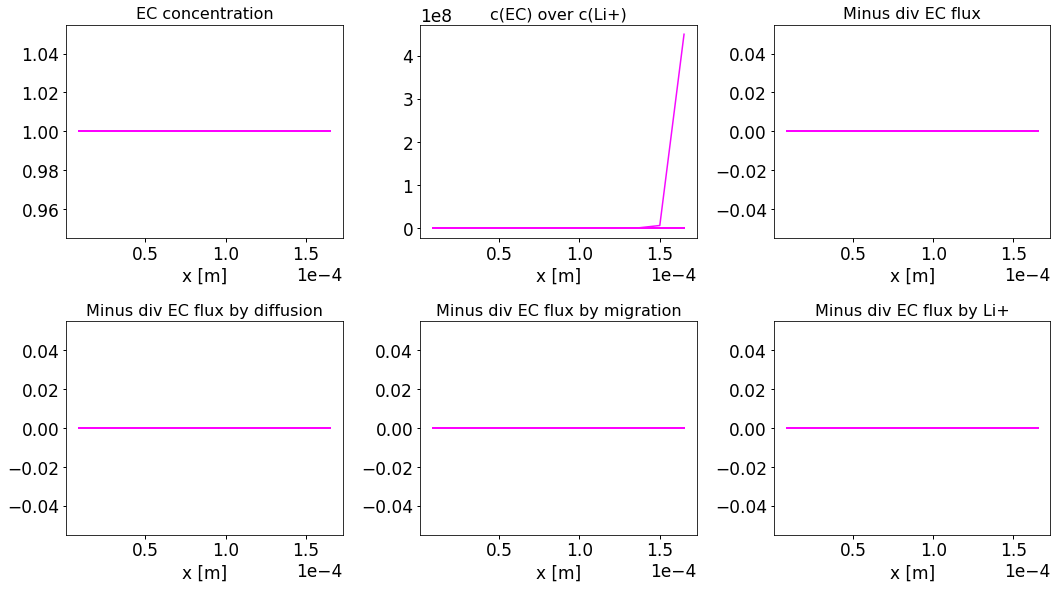

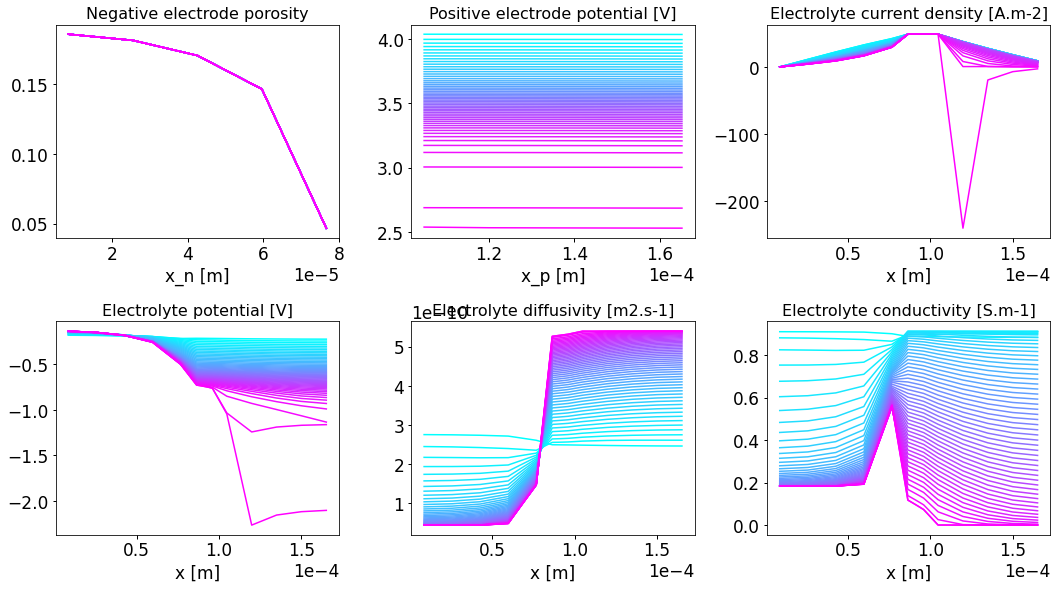

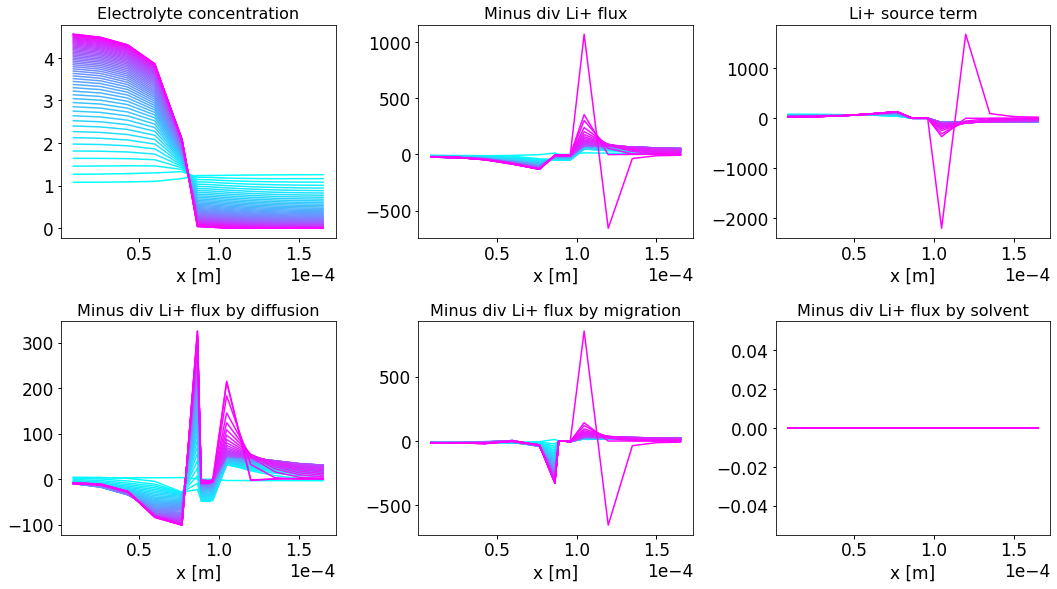

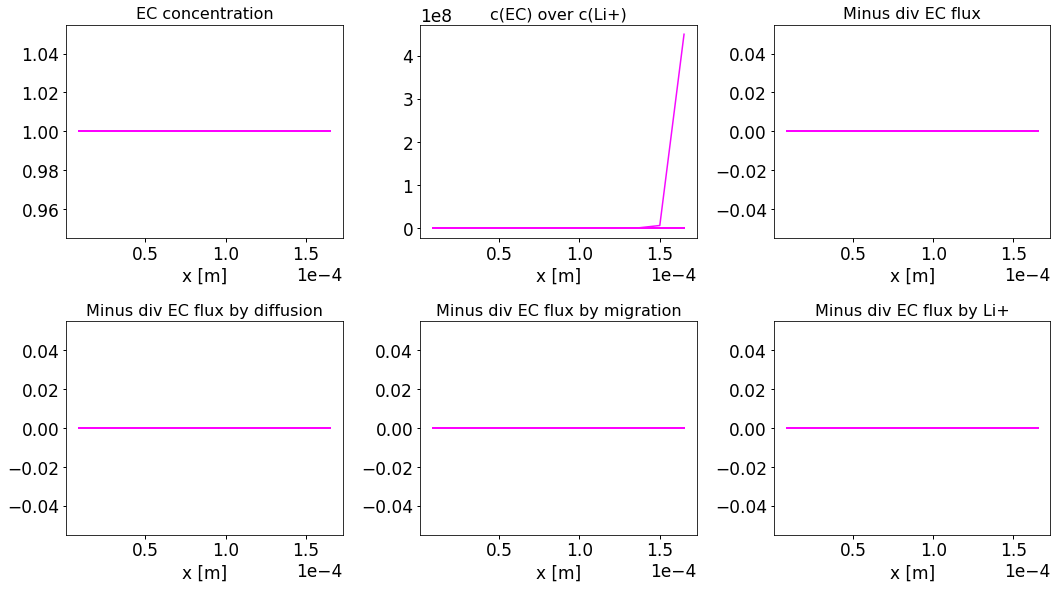

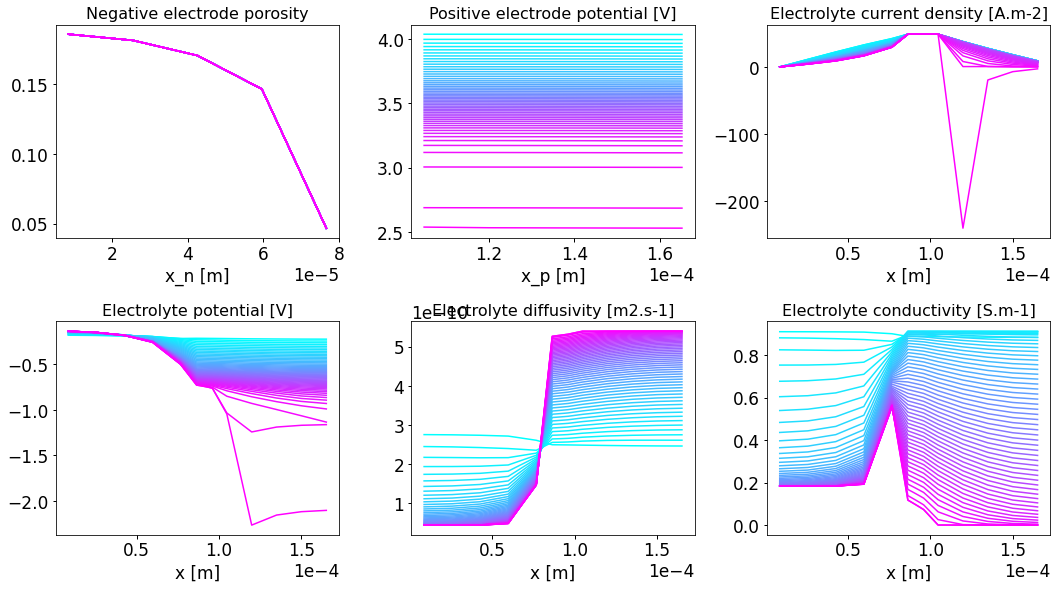

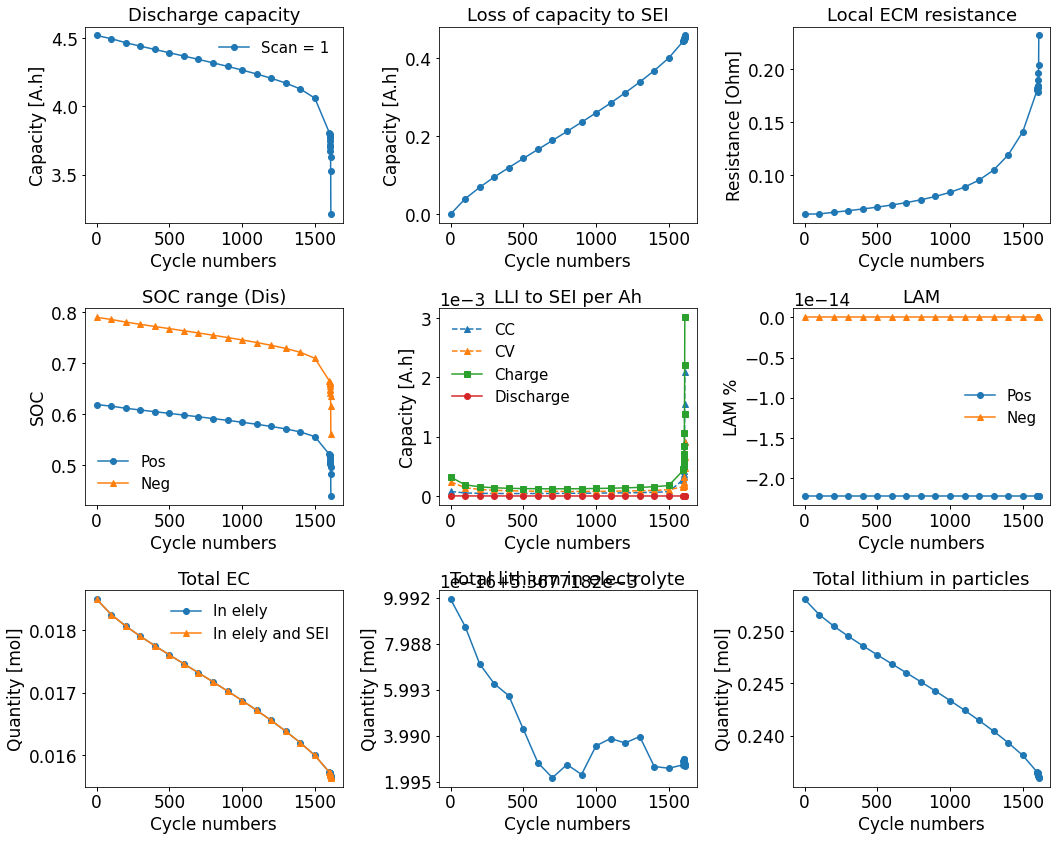

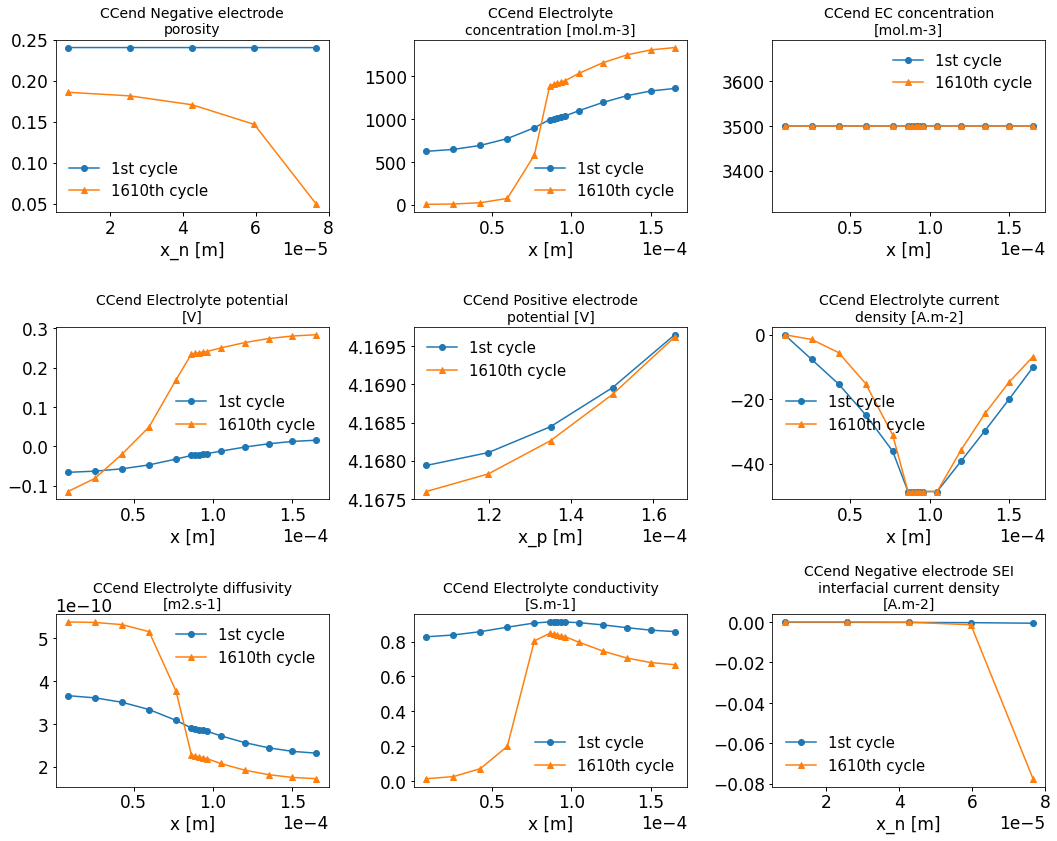

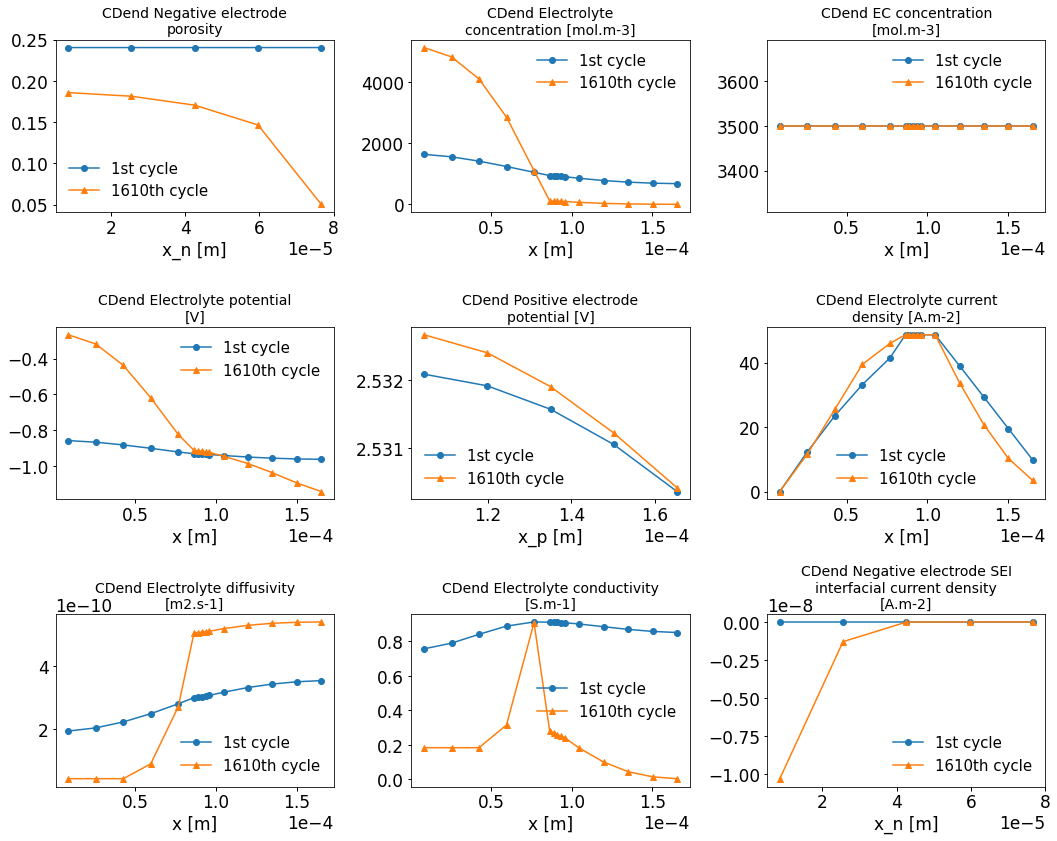

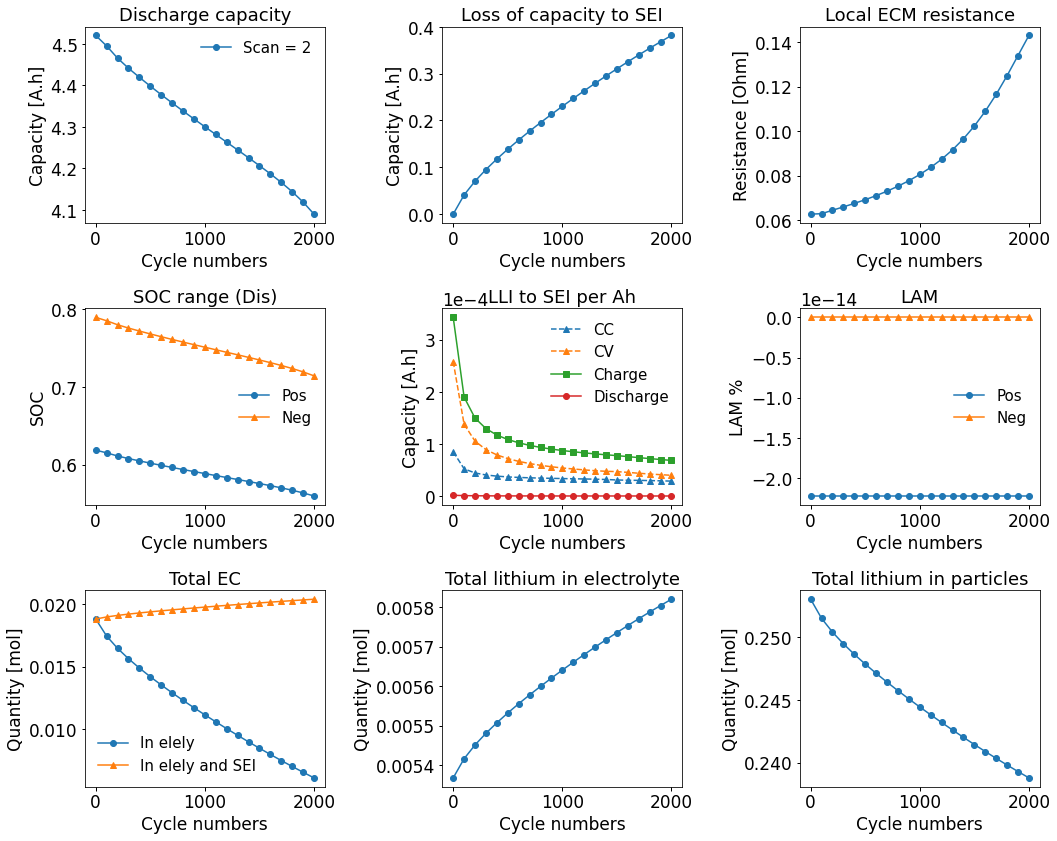

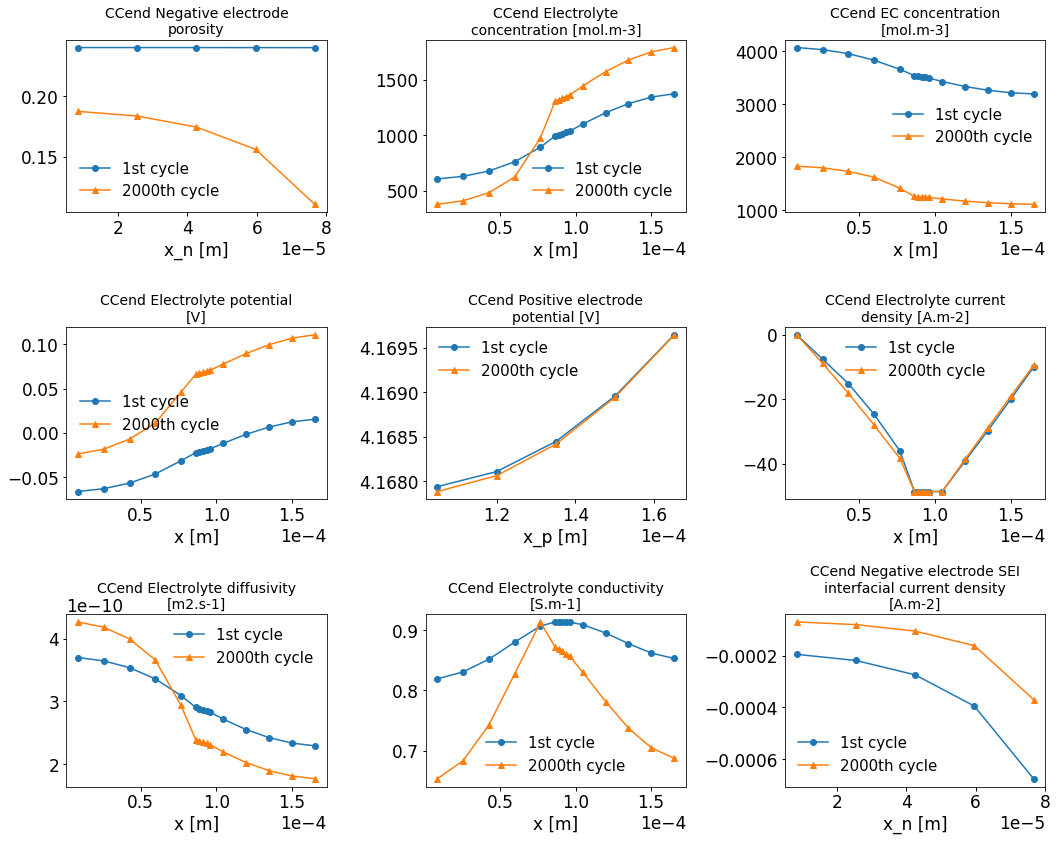

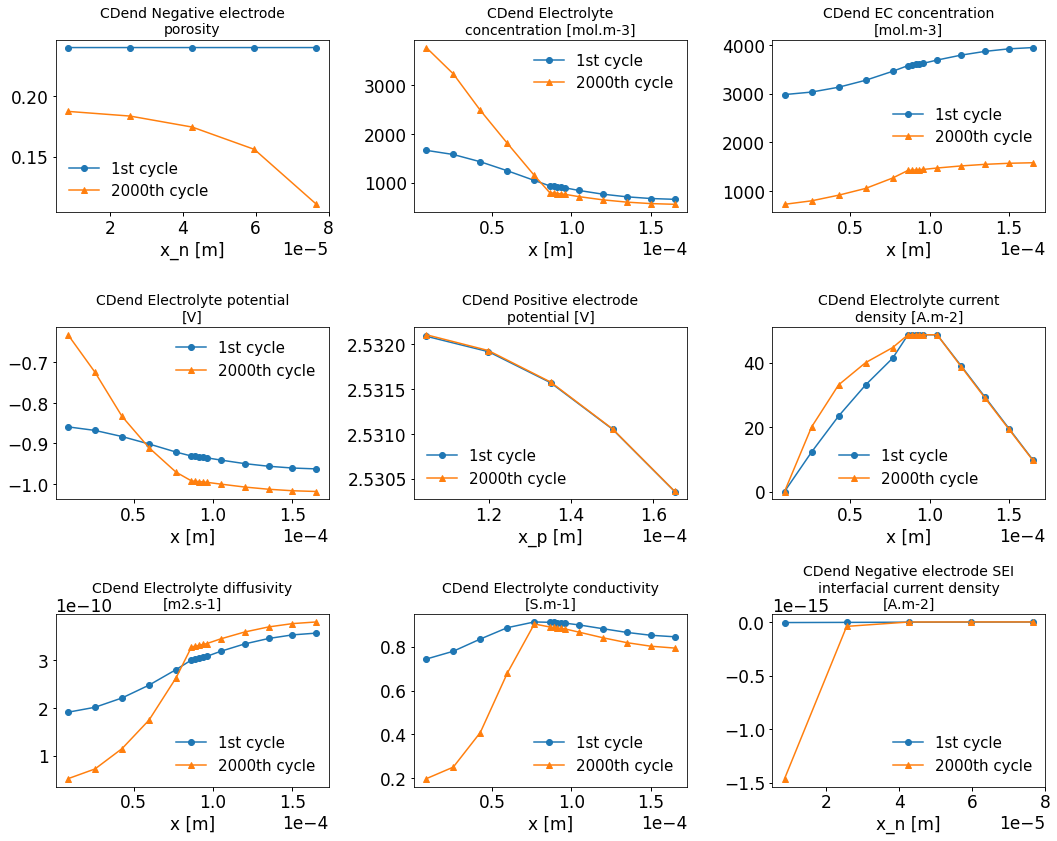

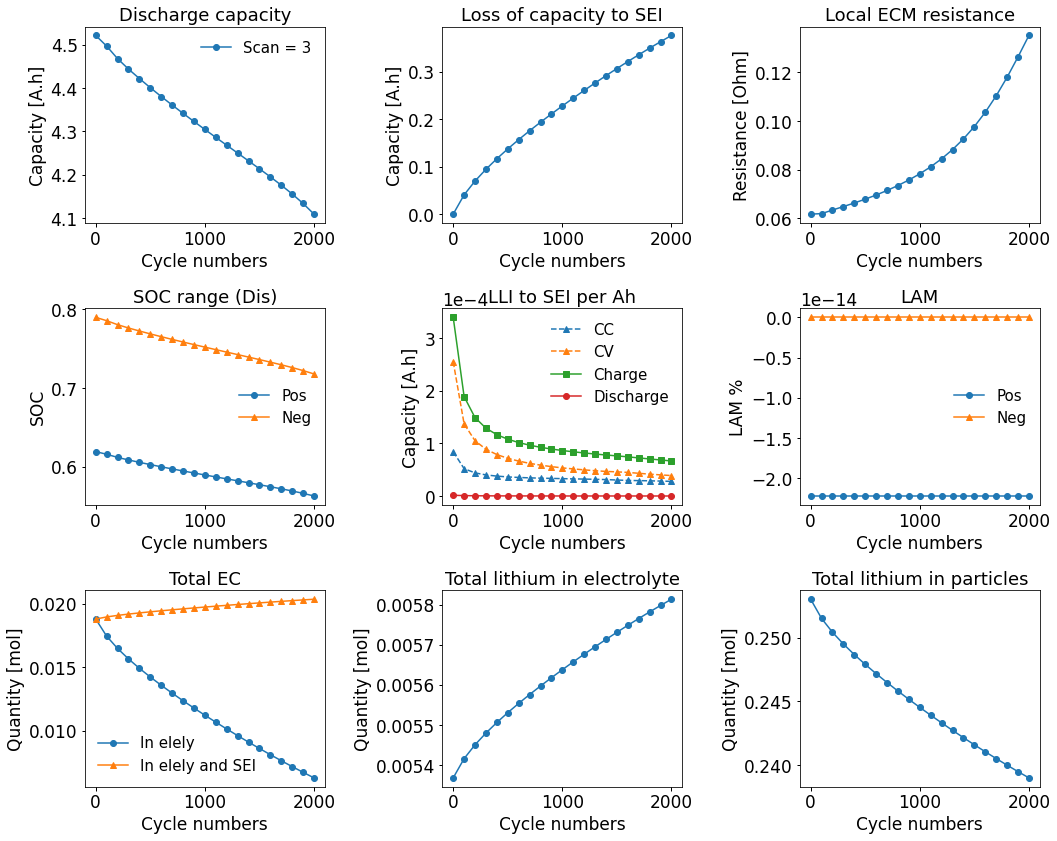

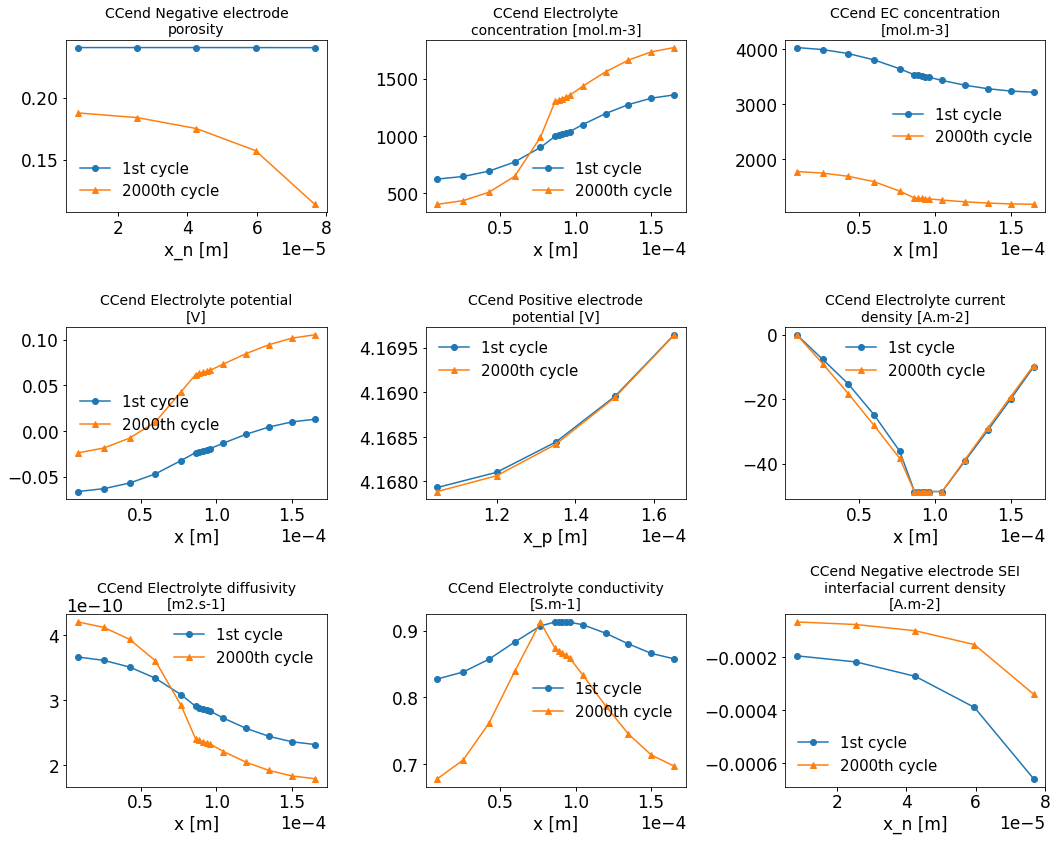

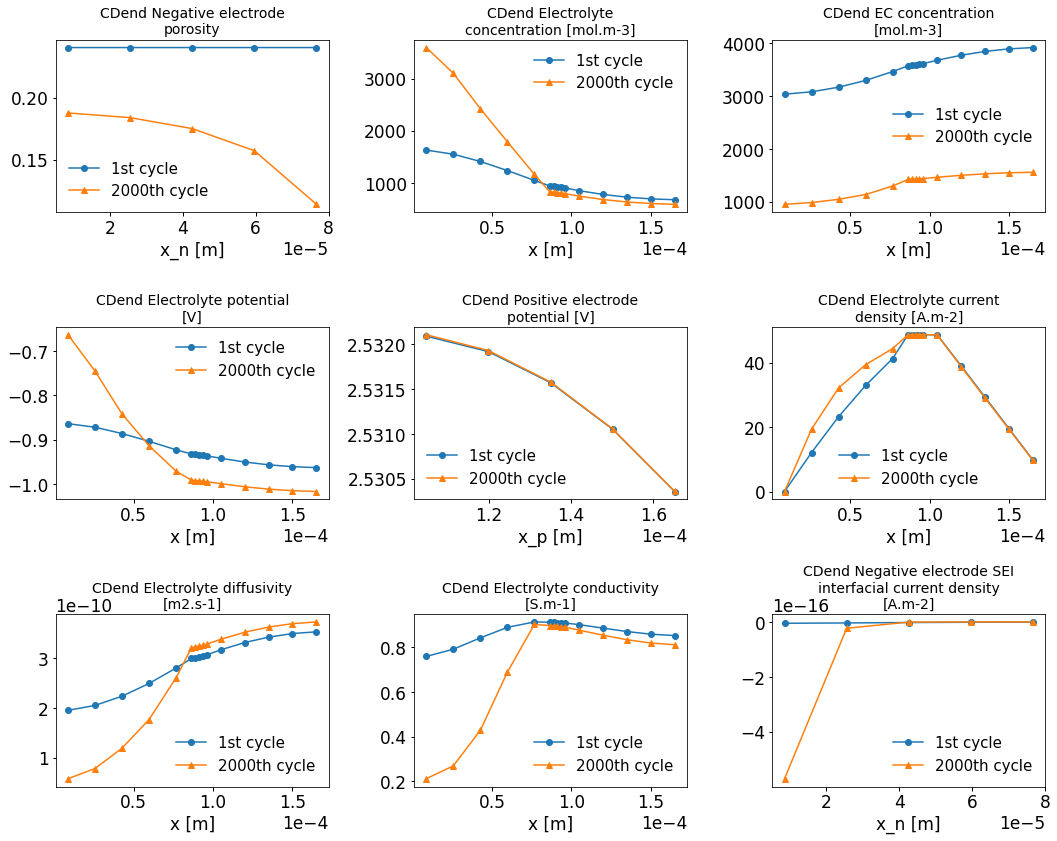

In [7]:
Results = []; Index = np.arange(1,len(Para_dict_list)+1).tolist()  
for Para_dict_i,index_i in zip(Para_dict_list,Index):
    Sol_all_i,j,midc_merge = Run_P3_model(
        index_i, Para_dict_i,   Path_pack , 
        keys_all_AGE,   Exp_AGE_List, exp_index_pack 
        ) 
    Results.append([Sol_all_i,j,midc_merge])

Index = np.arange(1,len(Para_dict_list)+1).tolist()  
if __name__ == "__main__":
    pool = multiprocessing.Pool(3)
    processes = [pool.apply_async(
        Run_P3_model, 
        args=(
            index_i, Para_dict_i,   Path_pack , 
            keys_all_AGE,   Exp_AGE_List, exp_index_pack 
         )   ) 
         for Para_dict_i,index_i in zip(Para_dict_list,Index)]
    result = [p.get() for p in processes] # 测试一下不保存会怎么样？

In [8]:

# Write all seperate excel files into a big file:
for i in Index:
    old_book = str(i) + '_' + book_name_xlsx
    #print(old_book)
    #open excel:
    try:   # use try just in case some cases fail
        data_old = openpyxl.load_workbook(BasicPath + Target + old_book)   
        data_tar = openpyxl.load_workbook(BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        tar_sheet_name_xlsx = 'Results';
        table_tar = data_tar[tar_sheet_name_xlsx]
        nrows_tar = table_tar.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)

        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {i}!")
    else:
        print(f"Successfuly write results for Scan {i}!") 

Successfuly write results for Scan 1!
Successfuly write results for Scan 1!
Successfuly write results for Scan 1!
